In [1]:
import os
import torch
import time
import torchvision.transforms as tt
import matplotlib.pyplot as plt


from torch import nn
from torchvision import models, datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm

In [2]:
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value

In [3]:
def train_model(model, dataloaders, criterion, optimizer,
                phases, num_epochs=3):
    start_time = time.time()

    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))

    return model, acc_history

In [4]:
input_size = 224
batch_size = 64

In [5]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

normalize = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)])

In [6]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *(means, stds))
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [7]:
def set_loaders(data_dir, show_examples=False):
    
    classes = os.listdir(data_dir + "/train")
    train_ds = ImageFolder(data_dir + '/train', normalize)
    valid_ds = ImageFolder(data_dir + '/val', normalize)


    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2)


    loaders = {'train': train_dl, 'val': valid_dl}
    if show_examples:
        show_batch(train_dl)
    return loaders

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setting origin model

In [10]:
model = models.resnet18(pretrained=True)
set_requires_grad(model, False)

num_ftrs = model.fc.in_features
origin_fc_layer = model.fc

/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
loaders = set_loaders('./data/imagenet-mini')

In [12]:
model = model.to(device)
train_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

set_requires_grad(model, False)
train_model(model, loaders, criterion, train_optimizer, phases=['val'], num_epochs=1)[1]

Epoch 0/0
----------


100%|██████████| 31/31 [00:08<00:00,  3.73it/s]

val Loss: 1.2709 Acc: 0.6898

Training complete in 0m 8s


{'val': [tensor(0.6898, device='cuda:0', dtype=torch.float64)]}

## Evaluate on ImageNette (without pretraining)

In [13]:
model.fc = nn.Linear(num_ftrs, 10)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [14]:
loaders = set_loaders('./data/imagenette2')

In [15]:
model = model.to(device)
train_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
set_requires_grad(model, False)
train_model(model, loaders, criterion, train_optimizer, phases=['val'], num_epochs=1)[1]

Epoch 0/0
----------


100%|██████████| 31/31 [00:07<00:00,  3.90it/s]

val Loss: 2.5236 Acc: 0.0887

Training complete in 0m 8s


{'val': [tensor(0.0887, device='cuda:0', dtype=torch.float64)]}

## Finetunning on CIFAR10

In [17]:
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=False, transform=normalize)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                           download=False, transform=normalize)
valid_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

loaders = {'train': train_dl, 'val': valid_dl}

In [18]:
set_requires_grad(model, True)
train_model(model, loaders, criterion, train_optimizer,
            phases=['train', 'val'], num_epochs=2)[1]

Epoch 0/1
----------


100%|██████████| 782/782 [00:43<00:00, 17.95it/s]


train Loss: 0.4894 Acc: 0.8438


100%|██████████| 157/157 [00:04<00:00, 35.65it/s]


val Loss: 0.2306 Acc: 0.9222

Epoch 1/1
----------


100%|██████████| 782/782 [00:43<00:00, 18.14it/s]


train Loss: 0.1784 Acc: 0.9410


100%|██████████| 157/157 [00:04<00:00, 36.76it/s]

val Loss: 0.1788 Acc: 0.9384

Training complete in 1m 35s


{'train': [tensor(0.8438, device='cuda:0', dtype=torch.float64),
  tensor(0.9410, device='cuda:0', dtype=torch.float64)],
 'val': [tensor(0.9222, device='cuda:0', dtype=torch.float64),
  tensor(0.9384, device='cuda:0', dtype=torch.float64)]}

## Eval on ImageNet

In [24]:
loaders = set_loaders('./data/imagenet-mini')

In [26]:
model.fc = origin_fc_layer
model = model.to(device)

### The model forgot the original dataset

In [27]:
set_requires_grad(model, False)
train_model(model, loaders, criterion, train_optimizer, phases=['val'], num_epochs=1)[1]

Epoch 0/0
----------


100%|██████████| 31/31 [00:08<00:00,  3.75it/s]

val Loss: 3.5527 Acc: 0.3033

Training complete in 0m 8s


{'val': [tensor(0.3033, device='cuda:0', dtype=torch.float64)]}

## Finetuninng on Imagenette

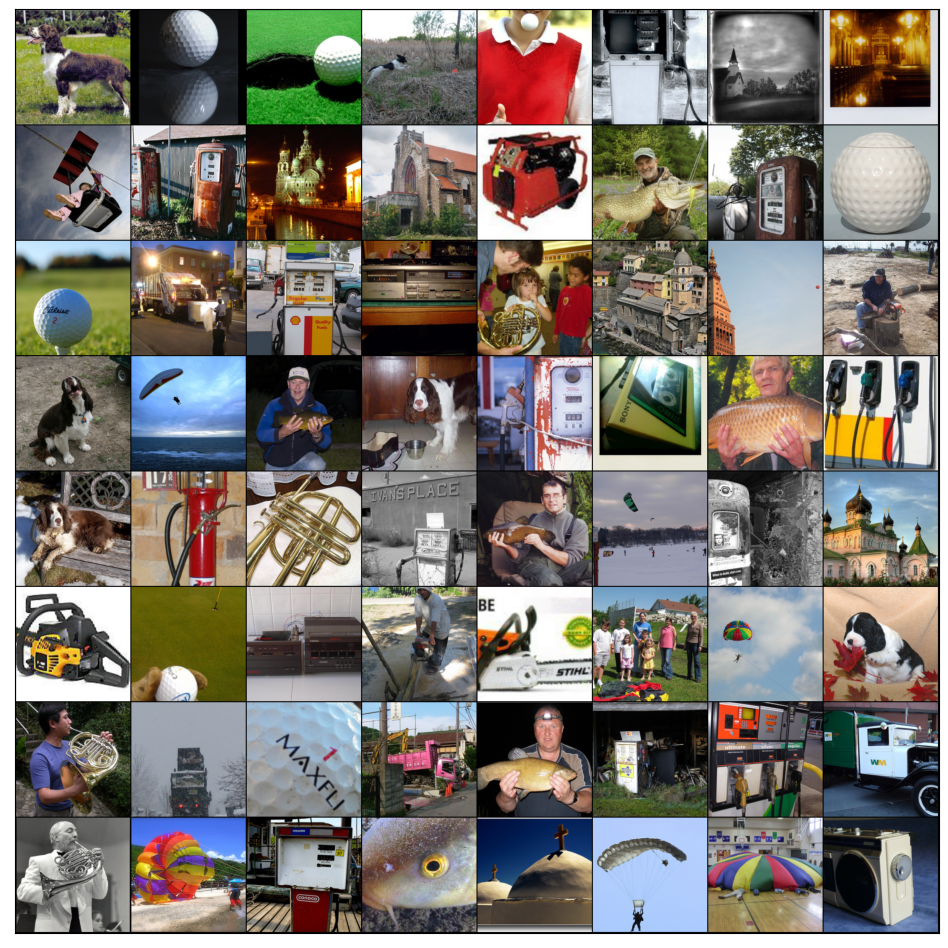

In [28]:
loaders = set_loaders('./data/imagenette2', show_examples=True)

In [33]:
model = model.to(device)
set_requires_grad(model, True)


pretrain_optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
train_model(model, loaders, criterion, pretrain_optimizer,
            phases=['train', 'val'], num_epochs=2)

TypeError: 'generator' object is not subscriptable

In [31]:
loaders = set_loaders('./data/imagenet-mini')
#model.fc = origin_fc_layer
model = model.to(device)
set_requires_grad(model, False)
train_model(model, loaders, criterion, train_optimizer, phases=['val'], num_epochs=1)[1]

Epoch 0/0
----------


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]

val Loss: 5.4121 Acc: 0.1700

Training complete in 0m 8s


{'val': [tensor(0.1700, device='cuda:0', dtype=torch.float64)]}